In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

## Dataset (males lastnames)
About ~9k lastnames

In [2]:
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [3]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

Name length ditribution

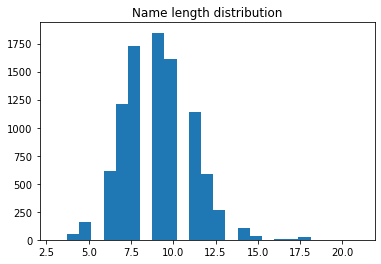

In [4]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

## Preprocessing

In [5]:
#all unique characters go here
tokens = list(set(''.join(names)))
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  53


### Character -> id

In [6]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [8]:
def to_matrix(data, token_to_id, max_len=None, dtype='float32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [9]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[36.  0. 33. 46. 33. 44. 42. 36. 36. 36.]
 [36. 29. 27. 23. 27. 46. 47. 27.  1. 48.]
 [36. 50. 15. 46. 23. 44. 42. 48. 36. 36.]
 [36. 20. 46. 44. 27. 46. 31. 44. 23. 22.]
 [36.  6. 15. 49.  1. 22. 44. 42. 36. 36.]]


## ESN NN

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torchvision import datasets, transforms

from IPython.display import clear_output
from random import sample

In [11]:
# !pip install easyesn

### Define ESN class

In [346]:
from easyesn import PredictionESN

class GenESN(nn.Module):
    def __init__(self, n_in, n_res, n_out, 
                 density=0.2, spec_radius=0.99, 
                 leaking_rate = 0, lin_size=64,
                 device=torch.device('cuda'), **params):
        super(GenESN, self).__init__()
        self.device = device
        
        self.n_in = n_in
        self.n_res = n_res
        self.n_out = n_out
        self.leaking_rate = leaking_rate

        # reservoir initiation
        try:
            self.Winput = params['w_input']
            self.Wreservoir = params['w_reservoir']
            print('External reservoir set')
        except:
            esn = PredictionESN(n_input=n_in - 1, n_reservoir=n_res, n_output=1,
                              reservoirDensity=density, spectralRadius=spec_radius,
                              weightGeneration='SORM')          
            self.Winput = torch.tensor(esn._WInput, requires_grad=False, dtype=torch.float32).to(device)
            self.Wreservoir = torch.tensor(esn._W, requires_grad=False, dtype=torch.float32).to(device)
            print('internal reservoir set')
            n_non_zero = esn._W[esn._W > 0.01].shape[0]
            print('Reservoir has {} non zero values ({:.2%})'.format(n_non_zero, 
                                                                   n_non_zero / (n_res ** 2) ))

        # readout layers
        self.readout_in = nn.Linear(n_res, lin_size)
        self.hidden_ro_layers = [nn.Linear(lin_size, lin_size).to(device) 
                                 for i in range(params['ro_hidden_layers'] - 1)]
        self.readout_out = nn.Linear(lin_size, self.n_out)

        self.dropout = nn.Dropout(p=0.05)
        self.softmax = nn.LogSoftmax()

        return     
        
    def forward(self, input, hidden_state, grad=True):
        
        hidden_state = torch.mm(self.Winput, input.T) + torch.mm(self.Wreservoir, hidden_state) 
        hidden_state = torch.tanh(hidden_state) 
        
        output = self.readout_in(hidden_state.T)
        if self.hidden_ro_layers:
            first_output = output.clone()
            for layer in self.hidden_ro_layers:
                output = layer(output)
            output += first_output
        output = self.readout_out(output)
        return   hidden_state, self.softmax(output)
          
    def init_hidden(self):
        """hidden state initiation"""
        return Variable(torch.zeros(self.n_res, 1, requires_grad=False)).to(self.device) 
    
    def add_hidden_emb(self, sequence): 
        self.embedding = torch.cat((self.embedding, sequence.cpu()), 0)

    def finalize(self):
        self.init_embedding = False

In [347]:
def compute_state(net, batch_index):
    batch_size, max_length, _ = batch_index.size()
    hid_state = net.init_hidden()
    logprobs = []

    for x_t in batch_index.transpose(0, 1):
        hid_state, logp_next = net(x_t.float().to(net.device), hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def lm_cross_entropy(pred, target):
    pred_flat = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[-1])  
    target_flat = target.view(-1) 
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

def scheduler(optimizer, patience):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=patience,
                                                      factor=0.5,
                                                      verbose=True)

In [348]:
def trainESN(net, n_epoch, lr_scheduler, batch_size=64, history=[], 
                    device=torch.device('cuda'), data=names):
    
    for i in range(n_epoch):
        batch_ix = to_matrix(sample(data, batch_size), token_to_id, max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        one_hot_batch = torch.nn.functional.one_hot(batch_ix, len(tokens))
        
        sequence = compute_state(net, one_hot_batch)
        
        predicted_seq = sequence[:, :-1]
        actual_next_tokens = batch_ix[:, 1:].long().to(device)
      
        # loss = lm_cross_entropy(predictions_logp,actual_next_tokens)
        loss = - torch.mean(torch.gather(predicted_seq, dim=2, 
                                         index=actual_next_tokens[:, :, None]))

        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        lr_scheduler.step(loss)
        if (i + 1) % 100 == 0:
            plt.figure(figsize=(12, 4.5))
            plt.grid()
            clear_output(True)
            plt.plot(history, label='loss, lr = {}, epochs={} '.format(opt.param_groups[0]['lr'], i))
            plt.legend()
            plt.show()

### Create ESN instance

In [363]:
%%time
device = torch.device('cuda')
n_in = len(tokens)
n_res = 400
lin_size = 64
ro_hidden_layers = 1
density = 0.02

net = GenESN(n_in=n_in, n_res=n_res , n_out=len(tokens), ro_hidden_layers = 2 ,
             lin_size=lin_size, density=density, device=device) 
net.to(device)
print(net)

internal reservoir set
Reservoir has 1252 non zero values (0.78%)
GenESN(
  (readout_in): Linear(in_features=400, out_features=64, bias=True)
  (readout_out): Linear(in_features=64, out_features=53, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (softmax): LogSoftmax()
)
Wall time: 1.5 s


In [364]:
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = scheduler(opt, patience=200)
MAX_LENGTH = max(map(len, names))
history = []

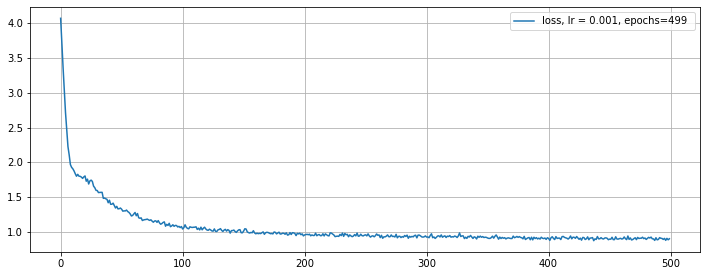

Wall time: 29.7 s


In [365]:
n_epoch = 500
batch_size = 300

%time trainESN(net,n_epoch=n_epoch, batch_size=batch_size, lr_scheduler=lr_scheduler, history=history)

### ESN generating

In [366]:
def generate_sample(net, seed_phrase=' ', max_length=MAX_LENGTH, 
                    temperature=1.0, enforce_end=False, device=torch.device('cuda')):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    with torch.no_grad():
        hid_state = net.init_hidden()
        for i in range(len(seed_phrase) - 1):
            x_t = x_sequence[:, i]
            x_t = torch.tensor(x_t.data, dtype=torch.int64)
            x_t = torch.nn.functional.one_hot(x_t, len(tokens))
            hid_state, _ = net(x_t.float().to(net.device), hid_state)

        for _ in range(max_length - len(seed_phrase)):
            x_t = x_sequence[:, -1]
            x_t = torch.tensor(x_t.data, dtype=torch.int64)
            x_t = torch.nn.functional.one_hot(x_t, len(tokens))

            hid_state, logp_next = net(x_t.float().to(net.device), hid_state)

            p_next = F.softmax(logp_next.cpu() / temperature, dim=-1).data.numpy()[0]

            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            if enforce_end and tokens[next_ix] == ' ':
                break
            x_sequence = torch.cat([x_sequence.float(), next_ix.to(device).float()], dim=1)
        
        
    return ''.join([tokens[ix] for ix in x_sequence.int().cpu().data.numpy()[0]])

In [367]:
for _ in range(10):
    print(generate_sample(net, temperature=1.0,seed_phrase=' '))

 Zhilovuz            
 Gokhov              
 Nasuheviko          
 Thamashin           
 Arebo               
 Valihin             
 Bairkenev           
 Lubkin              
 Tzamuhen            
 Firenkov            


In [373]:
for _ in range(10):
    print(generate_sample(net, seed_phrase=' Zhu',temperature=0.8))

 Zhurinov            
 Zhurn               
 Zhuladkich          
 Zhurtin             
 Zhukhotsin          
 Zhulkin             
 Zhulin              
 Zhurokov            
 Zhultievich         
 Zhuevik             


### GridSearch Optimization hyperparams

In [0]:
from sklearn.model_selection import ParameterGrid

def GridSearchOptimizer(n_epoch=1000, batch_size=256, in_out=(1, len(tokens)), 
                        device=torch.device('cuda'), **params):
    try:
        prev_res = 0
        for param in ParameterGrid(params):
            print('Params: {}'.format(param))
            net = GenESN(n_in=in_out[0], n_res=param['n_res'], n_out=in_out[1],
                         lin_size=param['lin_size'],
                         density=param['density'],
                         device=device)
            net.to(device)
            lerning_rate = 1e-3
            opt = torch.optim.Adam(net.parameters(), lr=lerning_rate)
            lr_scheduler = scheduler(opt, patience=150)
            history = []
            for i in range(n_epoch):
                batch_ix = to_matrix(sample(names, batch_size), token_to_id, max_len=MAX_LENGTH)
                batch_ix = torch.tensor(batch_ix, dtype=torch.float32).to(device)
                logp_seq = compute_state(net, batch_ix)
                predictions_logp = logp_seq[:, :-1]
                actual_next_tokens = batch_ix[:, 1:].long().to(device)
                loss = -torch.mean(torch.gather(predictions_logp, dim=2, 
                                                index=actual_next_tokens[:,:,None]))
                # loss = lm_cross_entropy(predictions_logp,actual_next_tokens)
                loss.backward()
                opt.step()
                opt.zero_grad()
                history.append(loss.data.cpu().numpy())
            print('Loss function value: {} \n'.format(round(np.mean(history[-50:]), 3)))
    except KeyboardInterrupt:
        print('KeyboardInterrupt, stoping...')
        return 

In [66]:
GridSearchOptimizer(n_res=[800],
                    lin_size=[64, 100, 210],
                    density=[0.05, 0.1, 0.2])

Params: {'density': 0.05, 'lin_size': 64, 'n_res': 800}
internal reservoir set
Loss function value: 1.2949999570846558 

Params: {'density': 0.05, 'lin_size': 100, 'n_res': 800}
internal reservoir set
Loss function value: 1.1629999876022339 

Params: {'density': 0.05, 'lin_size': 210, 'n_res': 800}
internal reservoir set
Loss function value: 1.2879999876022339 

Params: {'density': 0.1, 'lin_size': 64, 'n_res': 800}
internal reservoir set
Loss function value: 1.2510000467300415 

Params: {'density': 0.1, 'lin_size': 100, 'n_res': 800}
internal reservoir set
Loss function value: 1.534999966621399 

Params: {'density': 0.1, 'lin_size': 210, 'n_res': 800}
internal reservoir set
Loss function value: 1.9320000410079956 

Params: {'density': 0.2, 'lin_size': 64, 'n_res': 800}
internal reservoir set
Loss function value: 1.2940000295639038 

Params: {'density': 0.2, 'lin_size': 100, 'n_res': 800}
internal reservoir set
Loss function value: 1.25 

Params: {'density': 0.2, 'lin_size': 210, 'n_re

### RNN implementation

In [374]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, 
                 rnn_num_units=64, device = torch.device('cuda:0')):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size).to(device)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units).to(device)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens).to(device)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x).to(device)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next = self.rnn_update(x_and_h)         
        h_next = F.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

In [375]:
def rnn_loop(rnn, batch_index):
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []
    for x_t in batch_index.transpose(0, 1):
        hid_state, logp_next = rnn(x_t.to(device), hid_state.to(device))  
        logprobs.append(logp_next)
    return torch.stack(logprobs, dim=1)

In [376]:
def trainRNN(rnn, n_epoch=1000,batch_size=250, max_length=MAX_LENGTH):
    for i in range(n_epoch):
        batch_ix = to_matrix(sample(names, batch_size), token_to_id, max_len=max_length)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logp_seq = rnn_loop(rnn, batch_ix)

        predictions_logp = logp_seq[:, :-1].to(device)
        actual_next_tokens = batch_ix[:, 1:].to(device)
        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))

        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        if (i + 1) % 100 == 0:
            clear_output(True)
            plt.figure(figsize=(10, 4.5))
            plt.grid()
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [377]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

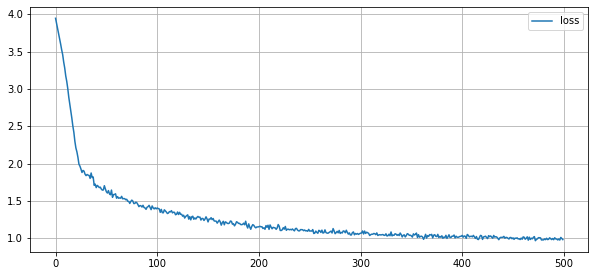

Wall time: 21.8 s


In [378]:
%%time
trainRNN(char_rnn, n_epoch=500, batch_size=300)

In [379]:
def generate_sample_rnn(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0,
                        enforce_end=False, device=torch.device('cuda')):    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        if enforce_end and tokens[next_ix] == ' ':
            break
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
       
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [381]:
for _ in range(10):
    print(generate_sample_rnn(char_rnn,temperature=0.8,seed_phrase=' Alpero'))

 Alperov             
 Alperosov           
 Alperov             
 Alperov             
 Alperotsev          
 Alperov             
 Alpero              
 Alperov             
 Alperov             
 Alperonkic          


### Evaluate and compare generated results. Vanilla RNN VS ESN

In [382]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from nltk import bleu

In [439]:
n_gen = 10
t = 0.9
rnn_generated = [generate_sample_rnn(char_rnn, seed_phrase=' ', temperature=t, enforce_end=True) \
                 for x in range(n_gen)]
esn_generated = [generate_sample(net, seed_phrase=' ', temperature=t, enforce_end=True) for x in range(n_gen)]

In [440]:
rnn_generated[:3], esn_generated[:3]

([' Zhevskyal', ' dutsevsko', ' Mendich'],
 [' Perobisky', ' Grahin', ' Kakitchin'])

In [454]:
def evaluate_gen(reference, candidates, is_sentence_bleu=False):
    sm_f = SmoothingFunction()
    min_bleu = 1
    score_lst = []
    for candidate in candidates:
        if is_sentence_bleu:
            score_lst.append(sentence_bleu(reference, candidate))
        else:
            score_lst.append(np.mean([bleu(ref, candidate, smoothing_function=sm_f.method1) 
                                      for ref in reference]))
    return score_lst
        

In [455]:
esn_generated[:5], rnn_generated[:5]

([' Perobisky', ' Grahin', ' Kakitchin', ' Murlagaev', ' Lizhanov'],
 [' Zhevskyal', ' dutsevsko', ' Mendich', ' Jdezkenihanev', ' Tyataittsn'])

In [456]:
%time score_lst = evaluate_gen(names, esn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 23.5 s
Eval mean: 0.0387 Eval min: 0.0272 Eval max: 0.0926


In [457]:
%time score_lst = evaluate_gen(names, rnn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 26.2 s
Eval mean: 0.0291 Eval min: 0.0208 Eval max: 0.0369


In [458]:
%time score_lst = evaluate_gen(names, esn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 3.15 s
Eval mean: 0.87 Eval min: 0.699 Eval max: 1.0


In [459]:
%time score_lst = evaluate_gen(names, rnn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 3.42 s
Eval mean: 0.679 Eval min: 1.07e-77 Eval max: 0.919


**Compare score by temperature**

In [460]:
%%time
n_gen = 100
n_neg_sample = 500
temperature = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
is_sentence_bleu = True

rnn_gen_mean_lst = []
esn_gen_mean_lst = []
rnn_gen_min_lst = []
esn_gen_min_lst = []
rnn_gen_max_lst = []
esn_gen_max_lst = []

for t in temperature:
    print('Temperature {}'.format(t))
    sample_data = sample(names, n_neg_sample)
    rnn_generated = [generate_sample_rnn(char_rnn, seed_phrase=' ', temperature=t, enforce_end=True) \
                     for x in range(n_gen)]
    score_lst = evaluate_gen(sample_data, rnn_generated, is_sentence_bleu=is_sentence_bleu)
    rnn_gen_mean_lst.append(np.mean(score_lst))
    rnn_gen_min_lst.append(min(score_lst))
    rnn_gen_max_lst.append(max(score_lst))
    
    esn_generated = [generate_sample(net, seed_phrase=' ', temperature=t, enforce_end=True) for x in range(n_gen)]
    score_lst = evaluate_gen(sample_data, esn_generated, is_sentence_bleu=is_sentence_bleu)
    esn_gen_mean_lst.append(np.mean(score_lst))
    esn_gen_min_lst.append(min(score_lst))
    esn_gen_max_lst.append(max(score_lst))

Temperature 0.2
Temperature 0.3
Temperature 0.4
Temperature 0.5
Temperature 0.6
Temperature 0.7
Temperature 0.8
Temperature 0.9
Temperature 1
Wall time: 51.7 s


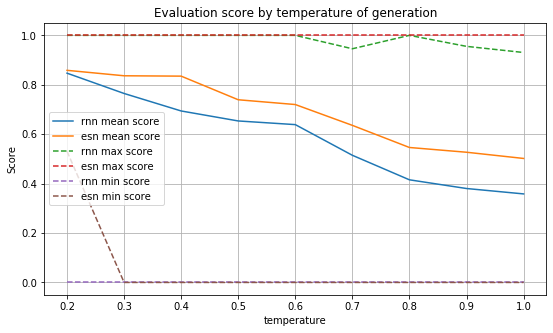

In [462]:
plt.figure(figsize=(9,5))
plt.plot(temperature,rnn_gen_mean_lst, label='rnn mean score')
plt.plot(temperature,esn_gen_mean_lst, label='esn mean score')
plt.plot(temperature,rnn_gen_max_lst, '--', label='rnn max score')
plt.plot(temperature,esn_gen_max_lst,'--', label='esn max score')
plt.plot(temperature,rnn_gen_min_lst,'--', label='rnn min score')
plt.plot(temperature,esn_gen_min_lst,'--', label='esn min score')
plt.xlabel('temperature')
plt.ylabel('Score')
plt.title('Evaluation score by temperature of generation')
plt.grid()
plt.legend()
plt.show()